In [3]:
%load_ext autoreload
%autoreload 2
%aimport


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [4]:
import numpy as np 
import pickle
import pandas as pd
from tqdm import tqdm

import multicam

import matplotlib.pyplot as plt


In [5]:

metadata_file = "../../data/processed/tng/tng300-1-table.csv"
tng_snapshot_dir = "../../data/processed/tng/TNG300-1/"  # everything is a host halo
tng_dark_snapshot_dir = "../../data/processed/tng/TNG300-1-Dark/"

trees_file = "../../data/processed/tng/TNG300-1_cut_trees.p"
present_snapfile = tng_snapshot_dir + "TNG300-1_HaloHistory_MBP_snap99.hdf5"

dark_trees_file = "../../data/processed/tng/TNG300-1-Dark_cut_trees.p"
present_dark_snapfile = tng_dark_snapshot_dir + "TNG300-1-Dark_HaloHistory_MBP_snap99.hdf5"

color_file = "../../data/processed/tng/Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc_099.hdf5"


## Read and match Hydro/DMO catalogs

In [6]:
from multicam.tng.utils import get_mpeak_from_mah, get_vmax_over_vvir, get_msmhmr, get_color, match_dm_and_hydro_cat, setup_mah_from_trees, match_mah_and_cat, rematch_dm_and_hydro_cat, MISSING, SNAPS, hydro_dm_match_pipeline


In [8]:
data = hydro_dm_match_pipeline(present_snapfile, present_dark_snapfile, trees_file, dark_trees_file, metadata_file, color_file, mass_bin=(12.8, 13.1), mbin_fudge = 0.2)


/Users/imendoza/code/nbody-relaxed/multicam/tng/utils.py:23: RuntimeWarning: divide by zero encountered in log10
  return np.where(gmass > 0, np.log10(gmass * 1e10 / TNG_H), 0)
/Users/imendoza/code/nbody-relaxed/multicam/tng/utils.py:23: RuntimeWarning: divide by zero encountered in log10
  return np.where(gmass > 0, np.log10(gmass * 1e10 / TNG_H), 0)
100%|██████████| 3293/3293 [00:39<00:00, 83.74it/s]
/Users/imendoza/code/nbody-relaxed/multicam/tng/utils.py:330: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cat["vmax/vvir"] = get_vmax_over_vvir(cat)


In [9]:
cat, dcat = data["cat"], data["dcat"]
len(cat), len(dcat)


(2931, 2931)

In [6]:
cat = pd.read_hdf(present_snapfile) # hydro
dcat = pd.read_hdf(present_dark_snapfile) # dark matter only

len(cat), len(dcat)


(13643, 13000)

In [7]:
cat, dcat = match_dm_and_hydro_cat(cat, dcat)

len(cat), len(dcat)
sum(cat['dmo_match'] != MISSING), sum(dcat['hydro_match'] != MISSING)


(12695, 12695)

In [8]:
mah_info = setup_mah_from_trees(trees_file, metadata_file, SNAPS)
dmah_info = setup_mah_from_trees(dark_trees_file, metadata_file, SNAPS)


/Users/imendoza/code/nbody-relaxed/multicam/tng/utils.py:23: RuntimeWarning: divide by zero encountered in log10
  return np.where(gmass > 0, np.log10(gmass * 1e10 / TNG_H), 0)
/Users/imendoza/code/nbody-relaxed/multicam/tng/utils.py:23: RuntimeWarning: divide by zero encountered in log10
  return np.where(gmass > 0, np.log10(gmass * 1e10 / TNG_H), 0)


In [9]:
mah, dmah = mah_info['mah'], dmah_info['mah']

halo_idx = mah_info['halo_idx']
dhalo_idx = dmah_info['halo_idx']

snaps, zs, scales = mah_info['snaps'], mah_info['z'], mah_info['scales']
dsnaps, dzs, dscales = dmah_info['snaps'], dmah_info['z'], dmah_info['scales']

assert np.all(snaps == dsnaps)
assert np.all(zs == dzs)
assert np.all(scales == dscales)


In [10]:
cat = match_mah_and_cat(halo_idx, cat)
dcat = match_mah_and_cat(dhalo_idx, dcat)

len(cat), len(dcat) 


(3293, 3854)

In [11]:
# finally rematch the hydro and dm catalogs from the columns we created.
cat, dcat, mah, dmah = rematch_dm_and_hydro_cat(cat, dcat, mah, dmah)


  0%|          | 0/3293 [00:00<?, ?it/s]

100%|██████████| 3293/3293 [00:20<00:00, 164.22it/s]


In [12]:
len(cat), len(dcat), mah.shape, dmah.shape


(2467, 2467, (2467, 80), (2467, 80))

In [13]:
m_peak, dm_peak = get_mpeak_from_mah(mah), get_mpeak_from_mah(dmah)


In [14]:
cat['vmax/vvir'] = get_vmax_over_vvir(cat)
dcat['vmax/vvir'] = get_vmax_over_vvir(dcat)


/var/folders/yl/5w7yl6bn1tsc5fjrdtsrsjhh0000gn/T/ipykernel_39517/2924787981.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cat['vmax/vvir'] = get_vmax_over_vvir(cat)


In [15]:
# get defragmented frames
cat = cat.copy()
dcat = dcat.copy()


In [16]:
gmass = mah[:, -1]
dgmass = dmah[:, -1]


In [17]:
msmhmr, _ = get_msmhmr(cat, gmass)
df_color = get_color(color_file, cat)
gr = (df_color['sdss_g'] - df_color['sdss_r']).values

msmhmr.shape, gr.shape


((2467,), (2467,))

In [18]:
# add to hydro catalog for good measure
cat['msmhmr'] = msmhmr
cat['g-r'] = gr


## Cross-Correlations

### Sanity check

/Users/imendoza/Library/Caches/pypoetry/virtualenvs/multicam-P7T5KfjX-py3.10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


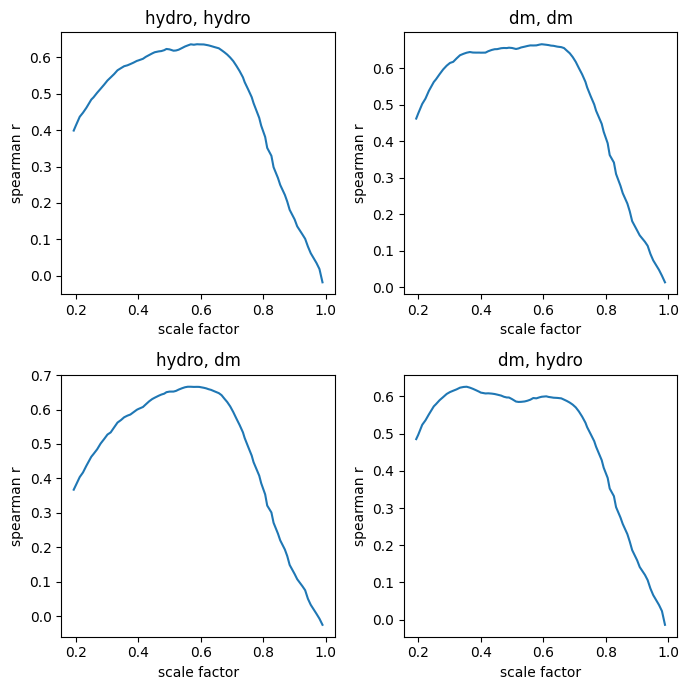

In [145]:
from multicam.correlations import spearmanr
fig, axes = plt.subplots(2, 2, figsize=(7, 7))
axes = axes.flatten()
corrs1 = [] 
corrs2 = []
corrs3 = [] 
corrs4 = []


for ii in range(mah.shape[1]): 
    corrs1.append(spearmanr(cat['cvir'], m_peak[:, ii]))
    corrs2.append(spearmanr(dcat['cvir'], dm_peak[:, ii]))
    corrs3.append(spearmanr(cat['cvir'], dm_peak[:, ii]))
    corrs4.append(spearmanr(dcat['cvir'], m_peak[:, ii]))

corrs = [corrs1, corrs2, corrs3, corrs4]
title = ['hydro, hydro', 'dm, dm', 'hydro, dm', 'dm, hydro']

for ax, corr in zip(axes, corrs):
    ax.plot(scales, corr)
    ax.set_xlabel('scale factor')
    ax.set_ylabel('spearman r')
    ax.set_title(title.pop(0))


plt.tight_layout()


### All DMO properties 

/Users/imendoza/Library/Caches/pypoetry/virtualenvs/multicam-P7T5KfjX-py3.10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


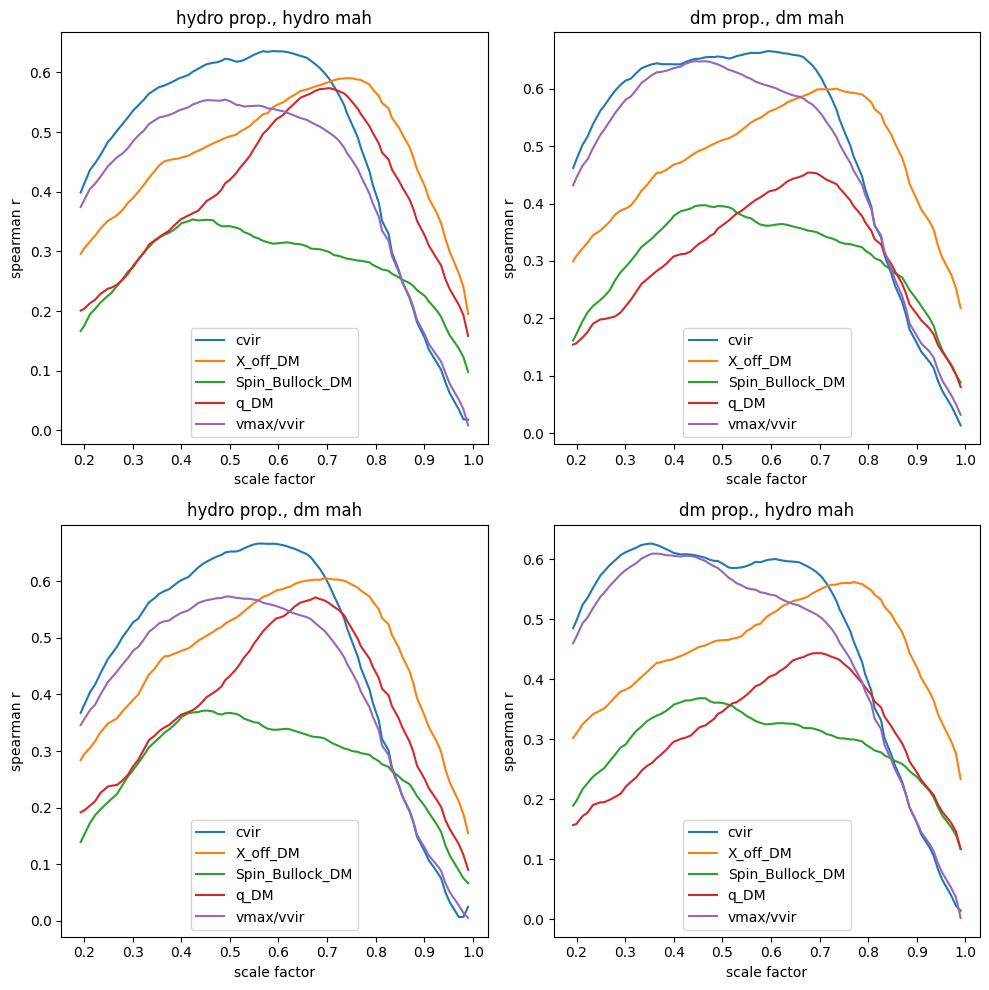

In [164]:
from multicam.correlations import spearmanr

dmo_params = ['cvir', 'X_off_DM', 'Spin_Bullock_DM', 'q_DM', 'vmax/vvir']

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

cat_peak_combs = [(cat, m_peak), (dcat, dm_peak), (cat, dm_peak), (dcat, m_peak)]
titles = ['hydro prop., hydro mah', 'dm prop., dm mah', 'hydro prop., dm mah', 'dm prop., hydro mah']

for ax, (_cat, _peak) in zip(axes, cat_peak_combs):
    for param in dmo_params:
        corrs = [] 
        for ii in range(_peak.shape[1]):
            corrs.append(abs(spearmanr(_cat[param], _peak[:, ii])))
        ax.plot(scales, corrs, label=param)

for ax, title in zip(axes, titles):
    ax.legend()
    ax.set_xlabel('scale factor')
    ax.set_ylabel('spearman r')
    ax.set_title(title)


plt.tight_layout()


### All Hydro properties

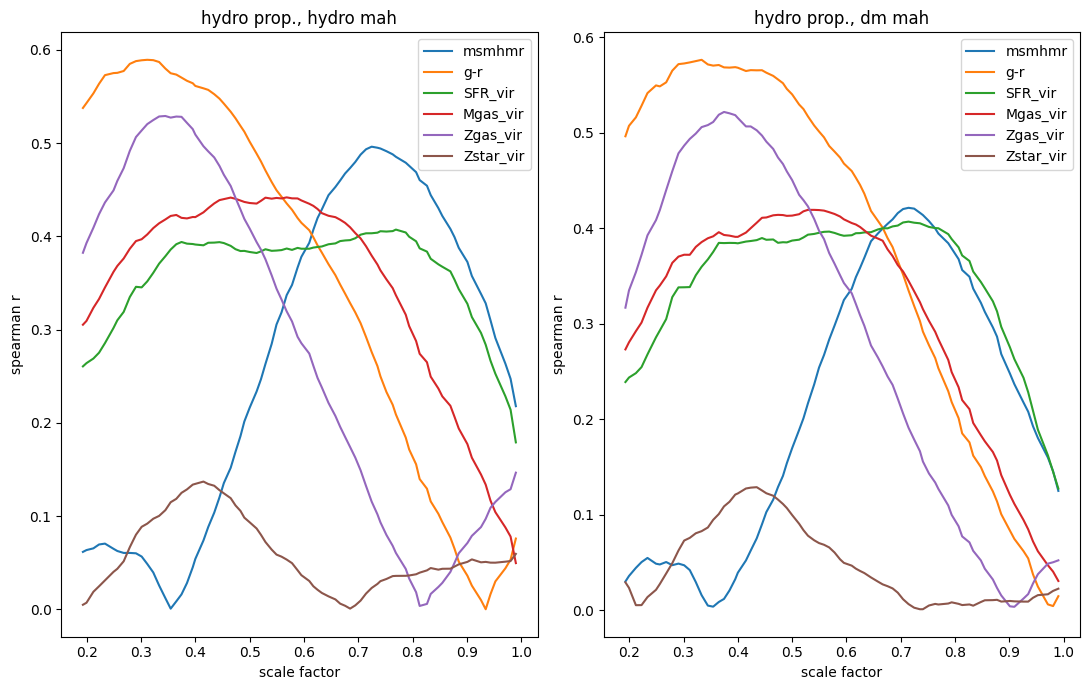

In [165]:
from multicam.correlations import spearmanr

hydro_params = ['msmhmr', 'g-r', 'SFR_vir', 'Mgas_vir', 'Zgas_vir', 'Zstar_vir']

fig, axes = plt.subplots(1, 2, figsize=(11, 7))
axes = axes.flatten()

cat_peak_combs = [(cat, m_peak), (cat, dm_peak)]
titles = ['hydro prop., hydro mah', 'hydro prop., dm mah']

for ax, (_cat, _peak) in zip(axes, cat_peak_combs):
    for param in hydro_params:
        corrs = [] 
        for ii in range(_peak.shape[1]):
            corrs.append(abs(spearmanr(_cat[param], _peak[:, ii])))
        ax.plot(scales, corrs, label=param)

for ax, title in zip(axes, titles):
    ax.legend()
    ax.set_xlabel('scale factor')
    ax.set_ylabel('spearman r')
    ax.set_title(title)


plt.tight_layout()


## MultiCAM rho spearman corrs


In [170]:
from multicam.models import MultiCAM 

n_features = m_peak.shape[1]
n_targets = len(dmo_params) + len(hydro_params)
all_params = dmo_params + hydro_params


model_hydro = MultiCAM(n_features, n_targets)
model_dmo = MultiCAM(n_features, n_targets)

model_hydro.fit(m_peak, cat[all_params].values)
model_dmo.fit(dm_peak, cat[all_params].values)


In [196]:
# now use all dmo properties (from dmo catalog) to predict hydro
n_features = dm_peak.shape[1] + len(dmo_params)
n_targets = len(dmo_params) + len(hydro_params)
x = np.concatenate([dm_peak, dcat[dmo_params].values], axis=1)
y = cat[all_params].values
model_dmo_all = MultiCAM(n_features, n_targets)

model_dmo_all.fit(x, y)


In [197]:
hydro_pred = model_hydro.predict(m_peak)
dmo_pred = model_dmo.predict(dm_peak)
dmo_all_pred = model_dmo_all.predict(x)


In [202]:
plot_params = ['cvir', 'x0', 'spin_bullock', 'q', 'vmax/vvir', 'msmhmr', 'g-r', 'sfr', 'mgas', 'zgas', 'zstar']
all_params


['cvir',
 'X_off_DM',
 'Spin_Bullock_DM',
 'q_DM',
 'vmax/vvir',
 'msmhmr',
 'g-r',
 'SFR_vir',
 'Mgas_vir',
 'Zgas_vir',
 'Zstar_vir']

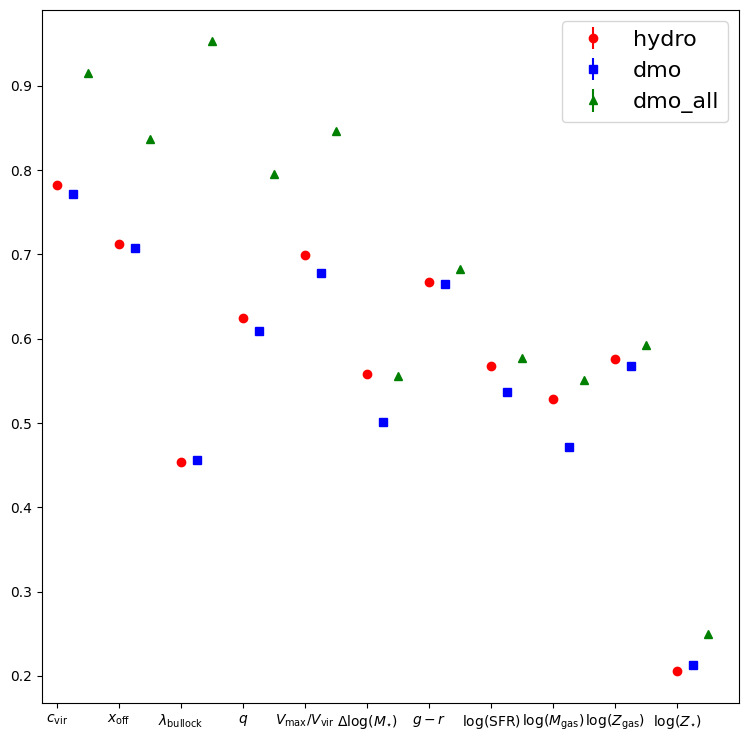

In [201]:
# compare spearman correlation plot of predictions from each model 
# x-axis is label with property predicted, y-axis is spearman r of prediction and truth
from multicam.correlations import spearmanr
from multicam.plotting import metrics_plot

# update rc plots fontsize 
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(1,1, figsize=(9, 9))

# corrs for hydro and dmo
hydro_corrs = []
dmo_corrs = []
dmo_all_corrs = [] 
for ii in range(hydro_pred.shape[1]):
    hydro_corrs.append(spearmanr(cat[all_params].values[:, ii], hydro_pred[:, ii]))
    dmo_corrs.append(spearmanr(cat[all_params].values[:, ii], dmo_pred[:, ii]))
    dmo_all_corrs.append(spearmanr(cat[all_params].values[:, ii], dmo_all_pred[:, ii]))

hydro_corrs = np.array(hydro_corrs)
dmo_corrs = np.array(dmo_corrs)
dmo_all_corrs = np.array(dmo_all_corrs)

metrics_plot(ax, hydro_corrs, np.zeros((11,)), plot_params, 'hydro', x_bias=0.0)
metrics_plot(ax, dmo_corrs, np.zeros((11,)), plot_params, 'dmo', x_bias=0.25, m='s', c='b')
metrics_plot(ax, dmo_all_corrs, np.zeros((11,)), plot_params, 'dmo_all', x_bias=0.5, m='^', c='g')

plt.legend(prop={'size': 16})


## Rank-order MultiCAM rho spearman corrs

In [88]:
from multicam.models import MultiCAM

exclude = ["HaloID", "SubhaloID", "SubhaloID_DMO", 'SubhaloID_LastDesc', 'Central', 'Main', 'EndState']

n_targets = len(set(cat.columns) - set(exclude))
hydro_params = list(set(cat.columns) - set(exclude))

dmodel = MultiCAM(80, n_targets)
model = MultiCAM(80, n_targets)

# remove nan's from hydro catalog
mask = np.isnan(cat[hydro_params].values).any(axis=1)
hydro_cat = cat[hydro_params]
_dm_peak = dm_peak[~mask]
_m_peak = m_peak[~mask]

x1 = _dm_peak
x2 = _m_peak
y = hydro_cat[:].values[~mask]

dmodel.fit(x1, y)
model.fit(x2, y)

# cat[hydro_params].values.shape


In [89]:
# compute all spearman correlations for every quantity not in exclude
from multicam.correlations import spearmanr
dcorrs = {} 
corrs = {}

y_pred1 = dmodel.predict(x1)
y_pred2 = model.predict(x2)

for jj, col in enumerate(hydro_cat.columns):
    dcorrs[col] = spearmanr(y[:, jj], y_pred1[:, jj])
    corrs[col] = spearmanr(y[:, jj], y_pred2[:, jj])


/Users/imendoza/Library/Caches/pypoetry/virtualenvs/multicam-P7T5KfjX-py3.10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [90]:
dvals = np.array(list(dcorrs.values()))
vals =  np.array(list(corrs.values()))

# get top 10 correlations columns (robust to nan's)
indices = np.argsort(vals)[::-1][:50]
for ii in indices:
    print(list(corrs.keys())[ii], vals[ii])


Nsat_Msub12 nan
SFR_10pkpc nan
tstar_vir 0.8409935205227259
tstar_200c 0.8360702068963718
tstar_10pkpc 0.828207912604954
tstar_30pkpc 0.8218706126137236
tstar_500c 0.8211507615471394
tstar_100pkpc 0.8086842557260595
tstar_2500c 0.8059329054178568
rho_s 0.7951867463841827
cvir 0.7820859980910835
rho_s_init 0.7710143264774898
cvir_init 0.7593638698356828
X_off_DM 0.7159724154295933
V_off_DM 0.7145790644827499
vmax/vvir 0.7028088823292203
M_s_gas 0.6811149828654391
X_off_star 0.6728629965585299
g-r 0.667959493402511
shapesDM_N_iter 0.6607679052776301
Rhalf 0.65805079263302
Rhalf_stars 0.6527007741287918
V_off_star 0.6520526822866534
cvir_init_err 0.6453945765765392
R0p8_stars 0.641925212624963
s_DM 0.6302503196819794
M2500c 0.6287130354997784
R2500c 0.6287103286694886
q_DM 0.6228809753040986
rho_s_init_err 0.6225669439781164
M_4s 0.6187826612740254
shapesDM_N_partfrac 0.6167165759187049
R0p2_stars 0.6014289954374694
Nsat_Mstar10 0.5972343348355736
Nsat_Msub11 0.5927533561840709
Mbh_Cen 0.

### Prediction with no sampling

In [91]:
# top 4 parameters 
params = ['tstar_vir', 'M_s_gas', 'X_off_star', 'g-r']
indices = [list(corrs.keys()).index(param) for param in params]


In [92]:
# #  plot scattering relations for tstar_vir and `M_s_gas`
# fig, ax = plt.subplots(1, 1, figsize=(7, 7))
# ax.scatter(y[:, idx1], y[:, idx2], s=1)
# ax.scatter(y_pred2[:, idx1], y_pred2[:, idx2], s=1, c='r')


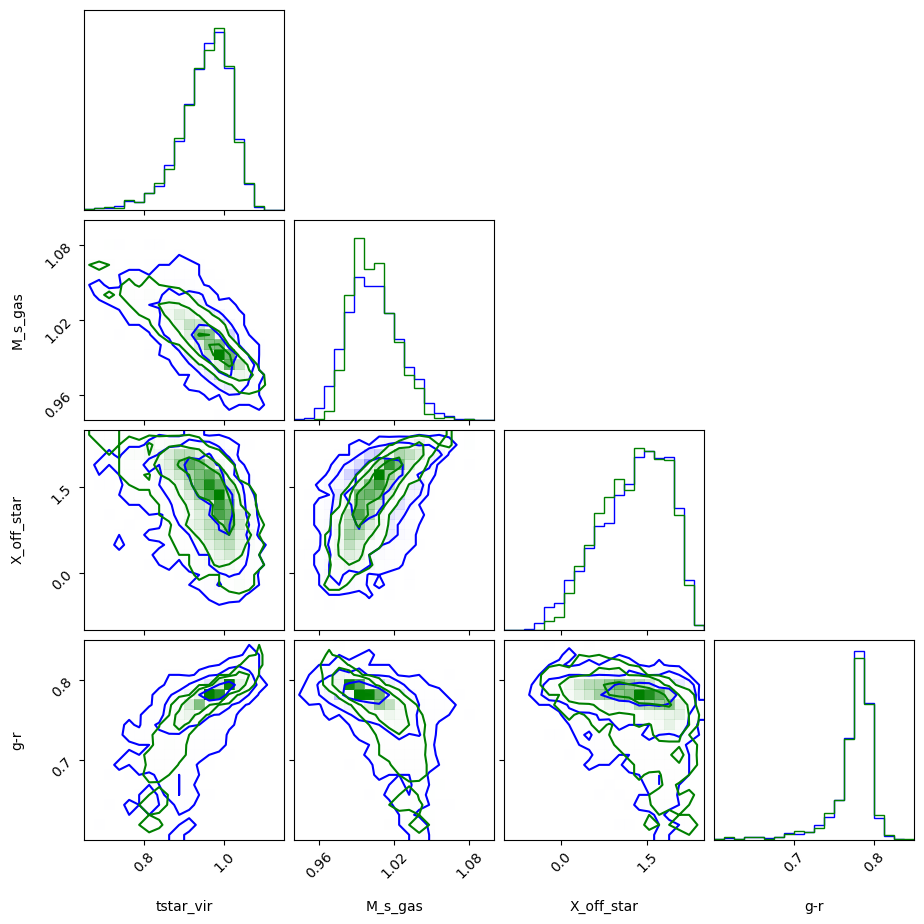

In [93]:
# try with corner 
import corner
levels = [1 - np.exp(-(x**2) / 2) for x in [1, 2, 3]]
ranges = [(0.65, 1.15), (0.94, 1.1), (-1, 2.5), (0.6, 0.85)]
do_log = [True, True, True, False]
y_log = [np.log10(y[:, jj]) if do_log[ii] else y[:, jj] for ii,jj in enumerate(indices)]
y_log = np.array(y_log).T
y_log1 = [np.log10(y_pred1[:, jj]) if do_log[ii] else y_pred1[:, jj] for ii,jj in enumerate(indices)]
y_log1 = np.array(y_log1).T
y_log2 = [np.log10(y_pred2[:, jj]) if do_log[ii] else y_pred2[:, jj] for ii,jj in enumerate(indices)]
y_log2 = np.array(y_log2).T

fig = corner.corner(y_log, max_n_ticks=3, plot_datapoints=False, levels=levels, bins=20, color='b', labels=params, range=ranges)
# fig = corner.corner(y_log1, max_n_ticks=3, plot_datapoints=False, levels=levels, bins=20, color='r', range=ranges, fig=fig)
fig = corner.corner(y_log2, max_n_ticks=3, plot_datapoints=False, levels=levels, bins=20, color='g', range=ranges, fig=fig, labels=params)


(array([ 0.        ,  0.12280552,  0.18420829,  1.22805524,  5.09642926,
        12.28055242, 21.24535569, 24.74531313, 19.95589769, 20.69273083,
        15.78050986, 11.29810823,  8.84199774,  4.35959611,  2.7631243 ,
         1.10524972,  0.30701381,  0.24561105,  0.06140276,  0.18420829]),
 array([0.94483491, 0.95147951, 0.95812411, 0.96476871, 0.97141331,
        0.97805791, 0.98470251, 0.99134711, 0.99799171, 1.00463631,
        1.0112809 , 1.0179255 , 1.0245701 , 1.0312147 , 1.0378593 ,
        1.0445039 , 1.0511485 , 1.0577931 , 1.0644377 , 1.0710823 ,
        1.0777269 ]),
 <BarContainer object of 20 artists>)

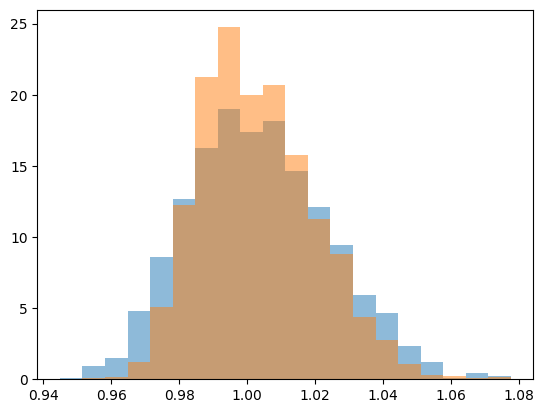

In [94]:
_, bins, _ = plt.hist(y_log[:, 1], bins=20, density=True, alpha=0.5, label='truth')
plt.hist(y_log1[:, 1], bins=bins, density=True, alpha=0.5, label='prediction')


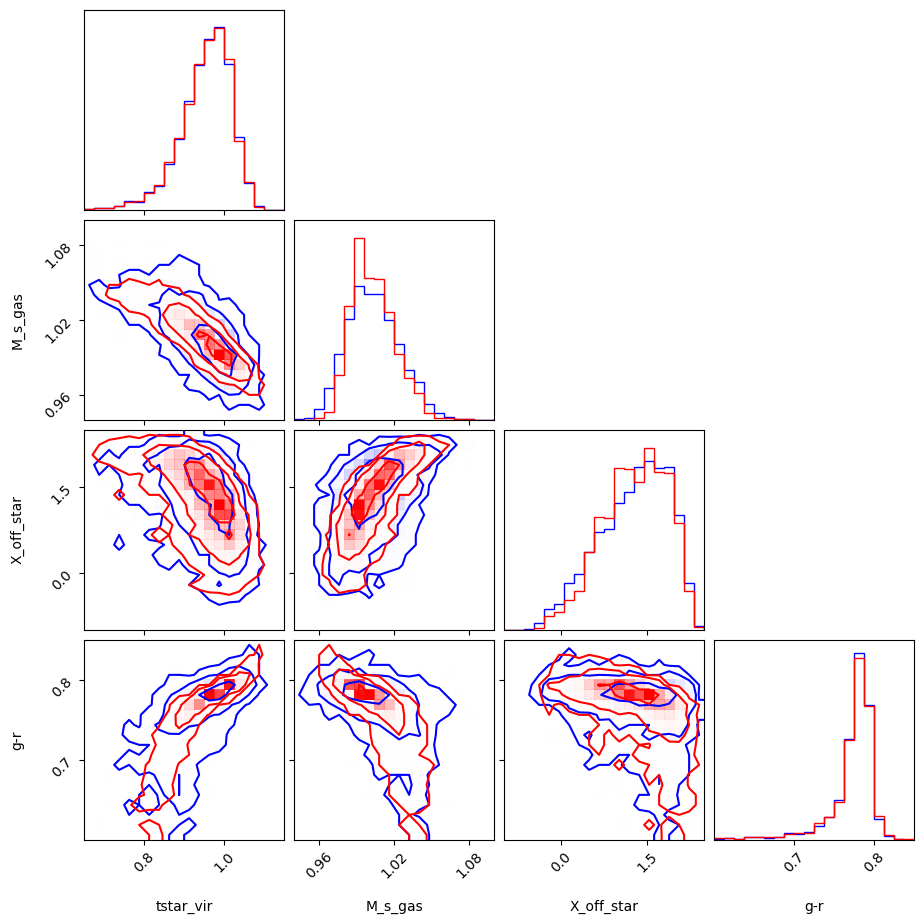

In [76]:
fig = corner.corner(y_log, max_n_ticks=3, plot_datapoints=False, levels=levels, bins=20, color='b', labels=params, range=ranges)
fig = corner.corner(y_log1, max_n_ticks=3, plot_datapoints=False, levels=levels, bins=20, color='r', range=ranges, fig=fig)
# fig = corner.corner(y_log2, max_n_ticks=3, plot_datapoints=False, levels=levels, bins=20, color='g', range=ranges, fig=fig, labels=params)


### What if we do sampling? 

In [125]:
y.shape


(2206, 7)

In [121]:
from multicam.models import MultiCamSampling

hydro_params =['tstar_vir', 'M_s_gas', 'X_off_star', 'g-r', 'msmhmr', 'Mstar_vir', 'SFR_vir']

n_targets = len(hydro_params)

mvg_dmodel = MultiCamSampling(80, n_targets)
mvg_model = MultiCamSampling(80, n_targets)

# remove nan's from hydro catalog
mask1 = np.isnan(cat[hydro_params].values).any(axis=1)
mask2 = np.absolute(cat[hydro_params].values[:, -1]) == np.inf
mask = mask1 | mask2

hydro_cat = cat[hydro_params]
_dm_peak = dm_peak[~mask]
_m_peak = m_peak[~mask]

x1 = _dm_peak
x2 = _m_peak
y = hydro_cat[:].values[~mask]

mvg_dmodel.fit(x1, y)
mvg_model.fit(x2, y)

# cat[hydro_params].values.shape


/Users/imendoza/Library/Caches/pypoetry/virtualenvs/multicam-P7T5KfjX-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/imendoza/Library/Caches/pypoetry/virtualenvs/multicam-P7T5KfjX-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


AssertionError: 

In [ ]:
y1 = mvg_dmodel.sample(x1, 1)
y1 = y1[:, 0, :]

y2 = mvg_model.sample(x2, 1)
y2 = y2[:, 0, :]

y1.shape


(2467, 6)

In [113]:
y[:, -1].min(), y[:, -1].max()


(10.642728250030359, 11.428003224883733)

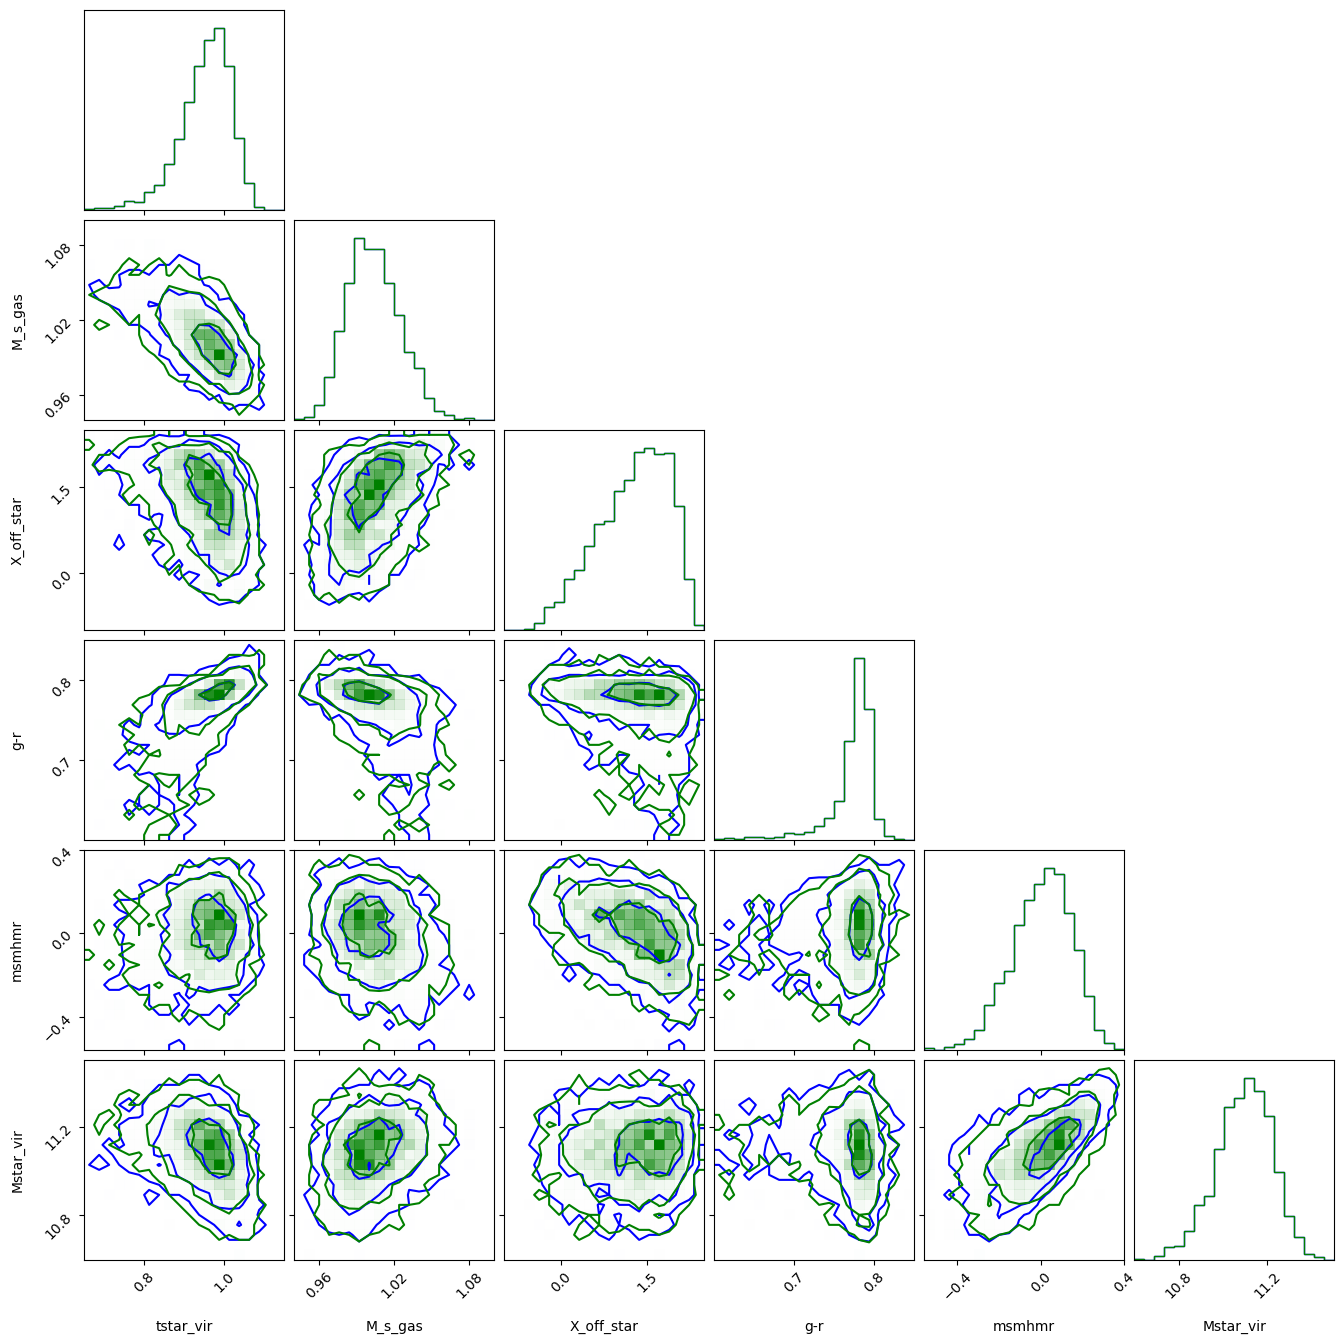

In [117]:
# try with corner 
import corner
levels = [1 - np.exp(-(x**2) / 2) for x in [1, 2, 3]]
ranges = [(0.65, 1.15), (0.94, 1.1), (-1, 2.5), (0.6, 0.85), (-0.56, 0.4), (10.6, 11.5)]
do_log = [True, True, True, False, False, False]
y_log = [np.log10(y[:, ii]) if do_log[ii] else y[:, ii] for ii in range(len(ranges))]
y_log = np.array(y_log).T
y_log1 = [np.log10(y1[:, ii]) if do_log[ii] else y1[:, ii] for ii in range(len(ranges))]
y_log1 = np.array(y_log1).T
y_log2 = [np.log10(y2[:, ii]) if do_log[ii] else y2[:, ii] for ii in range(len(ranges))]
y_log2 = np.array(y_log2).T

fig = corner.corner(y_log, max_n_ticks=3, plot_datapoints=False, levels=levels, bins=20, color='b', labels=hydro_params, range=ranges)
# fig = corner.corner(y_log1, max_n_ticks=3, plot_datapoints=False, levels=levels, bins=20, color='r', range=ranges, fig=fig)
fig = corner.corner(y_log2, max_n_ticks=3, plot_datapoints=False, levels=levels, bins=20, color='g', range=ranges,fig=fig)


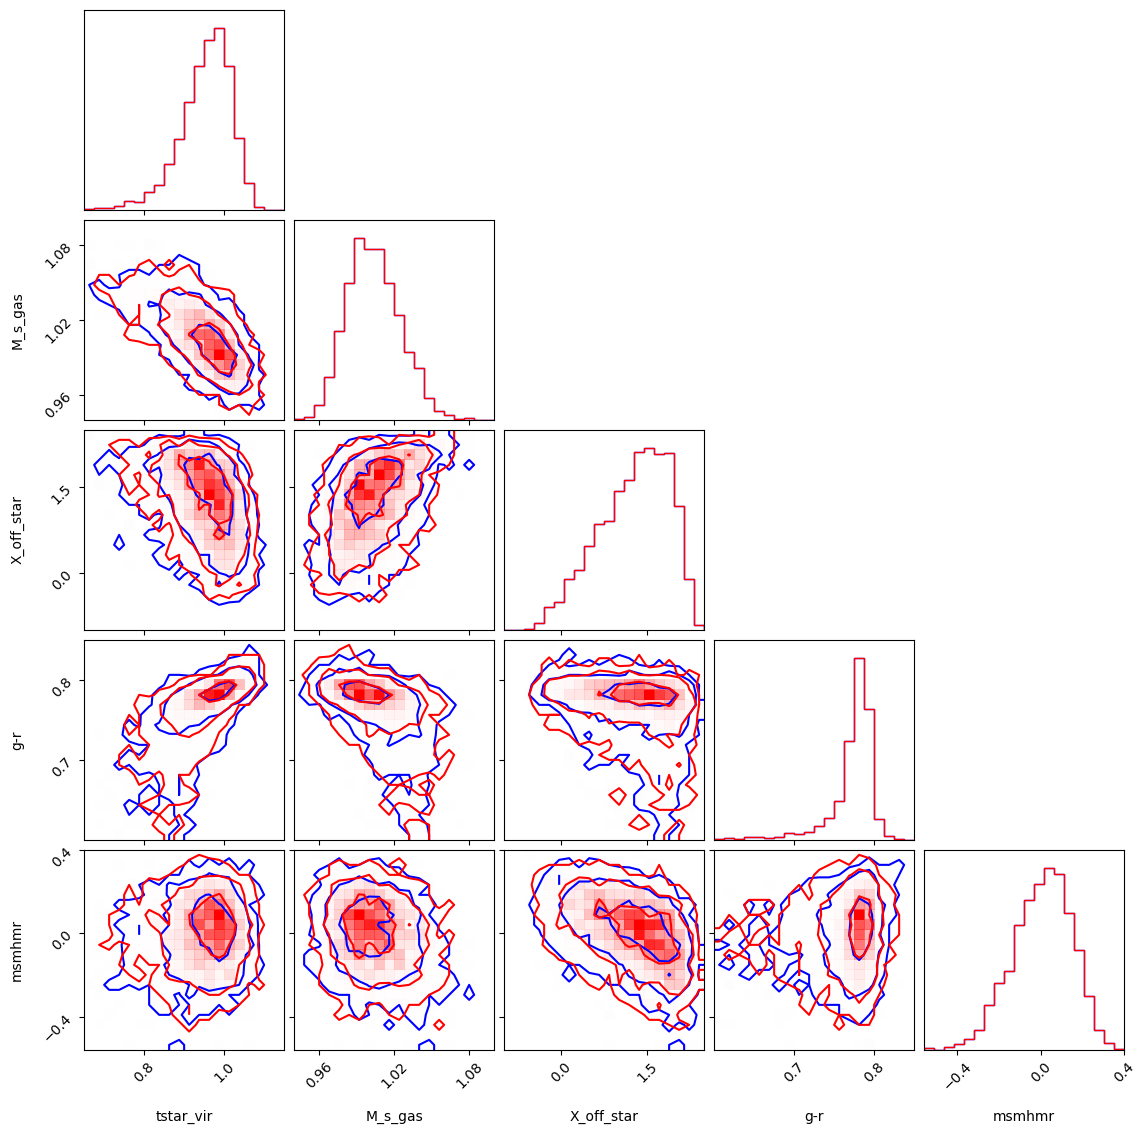

In [106]:

fig = corner.corner(y_log, max_n_ticks=3, plot_datapoints=False, levels=levels, bins=20, color='b', labels=hydro_params, range=ranges)
fig = corner.corner(y_log1, max_n_ticks=3, plot_datapoints=False, levels=levels, bins=20, color='r', range=ranges, fig=fig)
# fig = corner.corner(y_log2, max_n_ticks=3, plot_datapoints=False, levels=levels, bins=20, color='g', range=ranges, fig=fig, labels=params)


In [110]:
# compare cross correlations of predictions with truth
from multicam.correlations import spearmanr

for ii in range(y.shape[1]):
    for jj in range(1+ii, y.shape[1]):
        print(hydro_params[ii], hydro_params[jj])
        print(spearmanr(y[:, ii], y[:, jj]))
        print(spearmanr(y1[:, ii], y1[:, jj]))
        print(spearmanr(y2[:, ii], y2[:, jj]))
        print()


tstar_vir M_s_gas
-0.6795945403242402
-0.6722042519020194
-0.6723369926558832

tstar_vir X_off_star
-0.44213985790251953
-0.42129101413758524
-0.4127656713857093

tstar_vir g-r
0.7743779746696492
0.7732600972963732
0.7727621758877596

tstar_vir msmhmr
0.03158828966336364
0.02832171702080486
0.021907166849652052

M_s_gas X_off_star
0.492057840604826
0.49027885075588074
0.48652864492718945

M_s_gas g-r
-0.5804817508364891
-0.5697497027114767
-0.5735152261040638

M_s_gas msmhmr
-0.16886265517802532
-0.16561224464236746
-0.1568475857005229

X_off_star g-r
-0.27405084994676315
-0.2821178889413114
-0.282428420756889

X_off_star msmhmr
-0.49137793316844586
-0.47728889900676313
-0.47932395778639264

g-r msmhmr
0.13161105391259637
0.1361243626916649
0.13033385014379253



## Sandbox

In [47]:
c = pd.DataFrame(columns=['a', 'b'])
c.loc[0] = {'a':1, 'b':2}

c
c.loc[1] = dict(c.loc[0])

c


,a,b
0,1,2
1,1,2


In [46]:
dict(c.iloc[0])


{'a': 1, 'b': 2}

In [54]:
c.iloc[np.array([False, True])]


,a,b
1,1,2


In [58]:
mah.shape


(2467, 80)

In [ ]:
dmo_match_ii = cat["dmo_match"].values[1]
dmo_ids = dcat["dmo_id"].values
is_in = np.isin(dmo_ids, dmo_match_ii)
dict(dcat.iloc[np.where(is_in)[0].item()])
